In [30]:
import re
from collections import Counter

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

In [31]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bru/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
import sys
sys.path.append('../utils')
import sentiment_utils

In [33]:
films = pd.read_csv('../data/clean/letterboxd_clean_films.csv')

# load backup files
films_exploded_genres = pd.read_csv('../data/local/raw/letterboxd/films_exploded_genres.csv')
films_exploded_languages = pd.read_csv('../data/local/raw/letterboxd/films_exploded_languages.csv')
films_exploded_countries = pd.read_csv('../data/local/raw/letterboxd/films_exploded_countries.csv')
films_exploded_events = pd.read_csv('../data/local/raw/letterboxd/films_exploded_events.csv')
films_exploded_themes = pd.read_csv('../data/local/raw/letterboxd/films_exploded_themes.csv')

In [84]:
films.head()

,letterboxd_id,title,release_year,tagline,summary,runtime,letterboxd_rating,genres,language,countries,themes,director,topics,doesthedog_id,events,has_warnings
0,1000001,Barbie,2023,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114,3.86,"Comedy, Adventure",English,"UK, USA","['Humanity and the world around us', 'Crude hu...",Greta Gerwig,NaN,381345.0,NaN,False
1,1000002,Parasite,2019,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133,4.56,"Comedy, Thriller, Drama","Korean, English, German, Korean",South Korea,"['Humanity and the world around us', 'Intense ...",Bong Joon-ho,NaN,19408.0,NaN,False
2,1000003,Everything Everywhere All at Once,2022,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140,4.30,"Science Fiction, Adventure, Comedy, Action","English, Cantonese, Chinese, English",USA,"['Humanity and the world around us', 'Moving r...","Daniel Scheinert, Daniel Kwan",NaN,121671.0,NaN,False
3,1000004,Fight Club,1999,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139,4.27,Drama,English,"Germany, USA","['Intense violence and sexual transgression', ...",David Fincher,NaN,9593.0,NaN,False
4,1000005,La La Land,2016,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129,4.09,"Drama, Comedy, Music, Romance",English,"Hong Kong, USA","['Song and dance', 'Humanity and the world aro...",Damien Chazelle,"167,176,222,260,266,269,339,363",12823.0,"flashing lights or images, shower scenes, sad ...",True


In [34]:
films.dropna(subset=['genres', 'language', 'countries', 'director'], inplace=True)
cleaned_films = films.copy()
cleaned_films.dropna(inplace=True)

In [35]:
theme_counts = films_exploded_themes['themes'].value_counts().reset_index()
theme_ratings = films_exploded_themes.groupby('themes').agg(
    average_rating=('letterboxd_rating', 'mean'),
    count=('letterboxd_rating', 'count')
).reset_index()

Preprocess Text

In [36]:
# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabet characters
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Function to analyze the most common words and plot a pie chart
def analyze_most_common_words(df, text_column, top_n=50, save_path=None):
    processed_column = f"processed_{text_column}"
    
    # Preprocess the text column
    df[processed_column] = df[text_column].apply(preprocess_text)  # Assumes preprocess_text is defined
    
    # Flatten all tokens into a single list
    all_tokens = [word for tokens in df[processed_column] for word in tokens]
    total_word_count = len(all_tokens)
    
    # Count the most common words
    word_freq = Counter(all_tokens)
    most_common_words = word_freq.most_common(top_n)
    
    # Print results
    print(f"Top {top_n} most common words in '{text_column}':\n")
    print(f"{'Word':<15}{'Count':<10}{'Percentage (%)':<10}")
    print("-" * 35)
    for word, count in most_common_words:
        percentage = (count / total_word_count) * 100
        print(f"{word:<15}{count:<10}{percentage:.2f}")
    
    # Prepare data for Plotly
    words, counts = zip(*most_common_words)
    words_capitalized = [word.capitalize() for word in words]  # Capitalize the first letter of each word
    percentages = [round((count / total_word_count) * 100, 2) for count in counts]
    
    fig = go.Figure(data=[go.Pie(
        labels=words_capitalized,
        values=counts,
        hoverinfo='label+percent',
        textinfo='label+percent',
        textposition='outside',
        pull=[0.1] * len(words),
        marker=dict(colors=[
            '#F4D6A0',
            '#A8CBB7',
            '#D4B9A3',
            '#A6C6D9',
            '#B3A0A1',
            '#6E7B7A',
            '#99A7A4',
            '#C4D8C1',
            '#3E4A49',
            '#B8C6D0',
        ])
    )])

    fig.update_layout(
        title=f'Top Recurring Words in Events',
        showlegend=True, 
        plot_bgcolor='#f7f7f7', 
        paper_bgcolor='#f7f7f7',
        width=800
    )
    
    if save_path:
        fig.write_image(save_path)
        print(f"Plot saved to {save_path}")
        
    fig.show()
    
    return most_common_words

analyze_most_common_words(cleaned_films, text_column='events', top_n=10)

Top 10 most common words in 'events':

Word           Count     Percentage (%)
-----------------------------------
dying          4676      3.84
gore           3218      2.64
sexual         3153      2.59
scenes         2831      2.32
animals        2341      1.92
abuse          2336      1.92
dies           2025      1.66
violence       2010      1.65
blood          2006      1.65
people         1905      1.56


[('dying', 4676),
 ('gore', 3218),
 ('sexual', 3153),
 ('scenes', 2831),
 ('animals', 2341),
 ('abuse', 2336),
 ('dies', 2025),
 ('violence', 2010),
 ('blood', 2006),
 ('people', 1905)]

To understand how factors like themes, events, genres, and whether a title has warnings (has_warnings) impact the rating (letterboxd_rating), we can use statistical or machine learning techniques to analyze the relationships between these variables and the letterboxd_rating.

In [37]:
# films_exploded_themes = sentiment_utils.explode_column_from_string(cleaned_films.copy(), 'themes')
# films_exploded_genres = sentiment_utils.explode_column_from_string(cleaned_films.copy(), 'genres')
# films_exploded_events = sentiment_utils.explode_column_from_string(cleaned_films.copy(), 'events')

# print(films_exploded_themes[['title', 'themes']].head())
# print(films_exploded_genres[['title', 'genres']].head())
# print(films_exploded_events[['title', 'events']].head())

#### Scatter plot to show the correlation between themes and average ratings

In [38]:
# theme_ratings = films_exploded_themes.groupby('themes')['letterboxd_rating'].mean().reset_index()

# fig = px.scatter(theme_ratings, 
#                  x='themes',   
#                  y='letterboxd_rating',  
#                  title="Average Rating Correlation for Each Theme",
#                  labels={'letterboxd_rating': 'Average Rating', 'themes': 'Film Themes'},
#                  hover_data=['letterboxd_rating', 'themes'],  
#                  color='themes',  
#                  color_discrete_sequence=px.colors.qualitative.Set3)  


# fig.update_layout(
#     xaxis_title="Themes",
#     yaxis_title="Average Rating",
#     showlegend=True, 
#     plot_bgcolor='white',
#     height=800,  
#     margin=dict(l=100, r=100, t=50, b=150),  
#     xaxis_tickangle=70  
# )

# fig.show()

#### Violin plot to show the distribution of ratings by theme

In [39]:
fig = px.violin(films_exploded_themes,
                x='themes',
                y='letterboxd_rating',
                title="Distribution of Ratings by Theme",
                labels={'letterboxd_rating': 'Ratings', 'themes': 'Film Themes'},
                color='themes',  
                box=True,  # Show box plot inside the violin plot
                points='all',  
                color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(
    xaxis_title="Themes",
    yaxis_title="Ratings",
    xaxis_tickangle=45,  
    showlegend=False,  
    plot_bgcolor='white'
)

fig.show()

#### Word Cloud of Most Frequent Themes

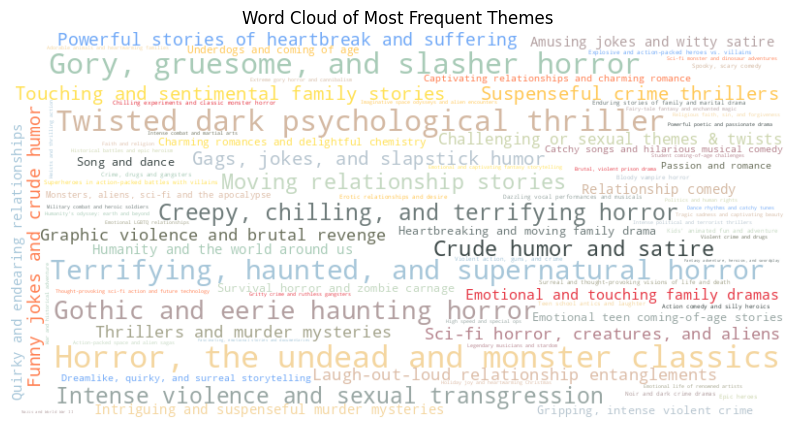

In [48]:
theme_counts_dict = dict(zip(theme_counts['themes'], theme_counts['count']))

# Custom color palette
custom_colors = [
    '#F4D6A0', '#A8CBB7', '#D4B9A3', '#A6C6D9', '#B3A0A1',
    '#6E7B7A', '#99A7A4', '#C4D8C1', '#3E4A49', '#B8C6D0',
    '#FFC857', '#FFE156', '#71A9F7', '#FF7F51', '#B5838D',
    '#6B705C', '#DDBEA9', '#A5A58D', '#CCD5AE', '#E63946'
]

# Define a custom color function based on the custom colors list
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Create a mapping of words to the custom color list
    color_idx = list(theme_counts_dict.keys()).index(word) % len(custom_colors)
    return custom_colors[color_idx]

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    color_func=color_func  # Apply custom color function
).generate_from_frequencies(theme_counts_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Most Frequent Themes')
plt.show()

In [49]:
# # Filter the top 20 themes by count
# top_20_themes = theme_ratings.nlargest(20, 'count')

# # Define the custom color palette
# custom_colors = [
#     '#F4D6A0', '#A8CBB7', '#D4B9A3', '#A6C6D9', '#B3A0A1',
#     '#6E7B7A', '#99A7A4', '#C4D8C1', '#3E4A49', '#B8C6D0',
#     '#FFC857', '#FFE156', '#71A9F7', '#FF7F51', '#B5838D',
#     '#6B705C', '#DDBEA9', '#A5A58D', '#CCD5AE', '#E63946'
# ]

# # Create the scatter plot for the top 20 themes
# fig = px.scatter(top_20_themes,
#                  x='average_rating', 
#                  y='themes',  
#                  size='count',  # Size of the bubbles based on theme frequency
#                  color='themes',  
#                  title="Top 20 Themes: Frequency vs. Average Rating",
#                  labels={'average_rating': 'Average Rating', 'themes': 'Film Themes'},
#                  color_discrete_sequence=custom_colors)

# fig.update_layout(
#     xaxis_title="Average Rating",
#     yaxis_title="Themes",
#     showlegend=False,  # Hide legend to avoid clutter
#     plot_bgcolor='white',
#     height=800,
#     width=1000,
#     xaxis_tickangle=45
# )

# fig.show()


In [50]:
# # Filter the top 20 themes by count
# top_20_themes = theme_ratings.nlargest(20, 'count')

# # Define a more refined, muted yet vivid color palette
# refined_colors = [
#     '#E27D60', '#85C1E9', '#6C5B7B', '#FFCF56', '#A9DFBF',
#     '#F5B041', '#5DADE2', '#AF7AC5', '#F1948A', '#7FB3D5',
#     '#58D68D', '#EB984E', '#85C1E9', '#48C9B0', '#D4AC0D',
#     '#85929E', '#B2BABB', '#D68910', '#E74C3C', '#7DCEA0'
# ]

# # Create the scatter plot for the top 20 themes
# fig = px.scatter(top_20_themes,
#                  x='average_rating', 
#                  y='themes',  
#                  size='count',  # Size of the bubbles based on theme frequency
#                  color='themes',  
#                  title="Top 20 Themes: Frequency vs. Average Rating",
#                  labels={'average_rating': 'Average Rating', 'themes': 'Film Themes'},
#                  color_discrete_sequence=refined_colors)

# fig.update_layout(
#     xaxis_title="Average Rating",
#     yaxis_title="Themes",
#     showlegend=True,  # Show the legend
#     plot_bgcolor='white',
#     height=800,
#     width=1000,
#     xaxis_tickangle=45,
#     xaxis=dict(tickformat='.2f')  # Show full rating values
# )

# fig.show()


In [ ]:
# Filter the top 15 themes by count
top_15_themes_list = theme_ratings.nlargest(15, 'count')['themes']
top_15_films = films_exploded_themes[films_exploded_themes['themes'].isin(top_15_themes_list)]

custom_colors = [
    '#F4D6A0', '#A8CBB7', '#D4B9A3', '#A6C6D9', '#B3A0A1',
    '#6E7B7A', '#99A7A4', '#C4D8C1', '#3E4A49', '#B8C6D0',
    '#FFC857', '#FFE156', '#71A9F7', '#FF7F51', '#B5838D',
    '#6B705C', '#DDBEA9', '#A5A58D', '#CCD5AE', '#E63946'
]

fig = px.box(top_15_films,
             x='themes', 
             y='letterboxd_rating',
             color='themes',
             title='Rating Distribution for Most Recurring Themes',
             labels={'letterboxd_rating': 'Letterboxd Rating', 'themes': 'Themes'},
             color_discrete_sequence=custom_colors)

fig.update_layout(
    xaxis_title='',
    yaxis_title='Rating',
    plot_bgcolor='#f7f7f7',
    paper_bgcolor='#f7f7f7',
    height=700,
    width=1300,
    xaxis_tickangle=30,
    showlegend=False
)

fig.show()

# image_path = '../visuals/rating_dist_top_15_themes.png'
# fig.write_image(image_path)

Step by Step